# Ranking de Habilidades Técnicas por Carrera

Este cuaderno permite leer los archivos de cada carrera (subcarpetas) finalizados con "_Merged.csv" dentro de la carpeta principal `todas_las_plataformas`, extraer habilidades (unigramas, bigramas, trigramas), definir manualmente un listado global de habilidades técnicas y obtener el ranking top 3 de habilidades técnicas por carrera.

## 1. Importar librerías necesarias
Importamos las librerías para manejo de archivos, procesamiento de texto y análisis de datos.

In [1]:
import os
import glob
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Configuración para mostrar más columnas
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 200)

## 2. Listar y leer archivos CSV de cada carrera
Buscamos recursivamente en la carpeta `todas_las_plataformas` todos los archivos que terminan con `_Merged.csv` y los leemos en dataframes individuales por carrera.

In [11]:
# Buscar archivos *_Merged.csv y cargar textos
ruta_base = 'todas_las_plataformas'
columnas_texto = ['skills', 'description', 'description_final', 'initial_skills', 'EURACE_skills']
corpus_carreras = {}
for subcarpeta in os.listdir(ruta_base):
    ruta_subcarpeta = os.path.join(ruta_base, subcarpeta)
    archivo_objetivo = os.path.join(ruta_subcarpeta, f'{subcarpeta}_Merged.csv')
    if os.path.isfile(archivo_objetivo):
        try:
            df = pd.read_csv(archivo_objetivo, dtype=str)
        except Exception as e:
            print(f'Error leyendo {archivo_objetivo}: {e}')
            continue
        textos = []
        for col in columnas_texto:
            if col in df.columns:
                textos.extend(df[col].dropna().tolist())
        corpus_carreras[subcarpeta] = ' '.join(textos)
# Mostrar información básica
df_ejemplo = pd.DataFrame({'carrera': list(corpus_carreras.keys()), 'texto': list(corpus_carreras.values())})
#print(df_ejemplo.head())
#print(f'Total carreras: {len(corpus_carreras)}')

In [12]:
df_ejemplo

,carrera,texto
0,Administración_de_Empresas,"Servicio al cliente, Ventas, Gestión de efectivo, Documentación, Supervisión del equipo Remediar itsm, Helix BMC, Servidor SQL, Kubernetes, Integración del sistema, Inglés Microsoft 365, Tendencia..."
1,Agroindustria,"Cualquier desviación debe comunicarse al supervisor de la planta y al gerente de control de calidad, ¡Estamos buscando un técnico de garantía de calidad para ayudar a nuestro equipo de preguntas y..."
2,Ciencia_de_Datos,"Más de 3 años de experiencia en desarrollo de software profesional no intermitente, Licenciatura o equivalente, Experiencia en el diseño o arquitectura (patrones de diseño, confiabilidad y escala)..."
3,Computación,"En general, estamos buscando un miembro del equipo que pueda trabajar bien con un equipo pequeño en un entorno acelerado, es competente en tareas técnicas y es un apasionado de la calidad., Siénte..."
4,Economía,"Sobresalir, Inteligencia de negocios, Power Bi, Sql, Pitón, Databricks Negociaciones internacionales, Habilidades de comunicación, Resistencia al estrés, Gobernanza ambiental, Implementación de la..."
5,Electricidad,"2 anos de experiencia minima como montador (preferencial), En construccion, albanileria, electricidad, electromecanica, trabajos en altura etc. (valorable), OFIMATICA: Ms Office 365 (Nivel usuario..."
6,Electrónica_y_Automatización,"El candidato ideal tendrá experiencia en tratamiento de agua y sistemas eléctricos trifásicos, Diploma de escuela secundaria / GED / Certificación de la escuela en casa o equivalente internacional..."
7,Física,"Licenciatura y mínimo 9 años de experiencia relevante previa, Graduado y un mínimo de 7 años de experiencia relacionada previa, En lugar de un título, un mínimo de 13 años de experiencia relaciona..."
8,Geología,"Grado avanzado (maestría o doctorado) en geología o campo relacionado, con especialización en génesis de mineral, sistemas minerales o geología estructural, Más de 15 años en exploración minera y ..."
9,Ingeniería_Ambiental,"Una licenciatura en un campo científico, de ingeniería o relacionado con 1-3 años de industria científica o experiencia regulatoria, La voluntad de desarrollar una sólida comprensión de las regula..."


In [19]:
# Whitelist: términos que SÍ son habilidades técnicas para todas las carreras
whitelist = {
    # Administración de Empresas
    'excel', 'power bi', 'erp', 'project management', 'sql', 'contabilidad', 'finanzas', 'marketing', 'gestión de recursos humanos', 'análisis financiero', 'auditoría', 'planificación estratégica', 'costos', 'presupuestos', 'negociación', 'comercio exterior', 'logística', 'supply chain', 'crm', 'ventas', 'administración de empresas',
    # Agroindustria
    'calidad', 'normas iso', 'producción', 'control de plagas', 'seguridad alimentaria', 'buenas prácticas agrícolas', 'procesamiento de alimentos', 'agronomía', 'fertilización', 'riego', 'manejo de cultivos', 'postcosecha', 'biotecnología', 'fitopatología', 'agroindustria', 'trazabilidad', 'certificación orgánica',
    # Ciencia de Datos
    'python', 'machine learning', 'data analysis', 'sql', 'r', 'big data', 'visualización de datos', 'estadística', 'deep learning', 'scikit-learn', 'pandas', 'numpy', 'matplotlib', 'data mining', 'análisis predictivo', 'regresión', 'clasificación', 'clustering', 'etl', 'modelado de datos', 'inteligencia artificial', 'análisis exploratorio', 'data science',
    # Computación
    'java', 'c++', 'python', 'linux', 'git', 'algoritmos', 'estructura de datos', 'sistemas operativos', 'redes', 'seguridad informática', 'programación orientada a objetos', 'desarrollo web', 'html', 'css', 'javascript', 'php', 'sql', 'c#', 'arquitectura de computadoras', 'compiladores', 'base de datos', 'ingeniería de software', 'testing', 'uml', 'scrum', 'devops',
    # Economía
    'econometría', 'estadística', 'finanzas', 'análisis de datos', 'excel', 'microeconomía', 'macroeconomía', 'modelos econométricos', 'análisis financiero', 'gestión de riesgos', 'mercados financieros', 'política económica', 'economía internacional', 'teoría de juegos', 'pronósticos', 'costos', 'presupuestos',
    # Electricidad
    'circuitos', 'electrónica', 'automatización', 'plc', 'motores eléctricos', 'instalaciones eléctricas', 'protecciones eléctricas', 'energía renovable', 'diseño eléctrico', 'subestaciones', 'mediciones eléctricas', 'generación eléctrica', 'distribución eléctrica', 'transformadores', 'sistemas eléctricos de potencia',
    # Electrónica y Automatización
    'plc', 'sensores', 'microcontroladores', 'automatización', 'circuitos', 'arduino', 'raspberry pi', 'robotica', 'sistemas embebidos', 'instrumentación', 'control automático', 'electrónica digital', 'electrónica analógica', 'scada', 'diseño de pcb', 'fpga', 'vhdl', 'proteus',
    # Física
    'simulación', 'matlab', 'python', 'análisis de datos', 'modelado', 'cálculo numérico', 'física computacional', 'teoría cuántica', 'óptica', 'mecánica clásica', 'termodinámica', 'electromagnetismo', 'análisis estadístico', 'instrumentación científica', 'latex',
    # Geología
    'gis', 'cartografía', 'sensores remotos', 'petrología', 'estratigrafía', 'geofísica', 'geotecnia', 'hidrogeología', 'mineralogía', 'mapeo geológico', 'análisis de suelos', 'modelado geológico', 'arcgis', 'qgis', 'geología estructural', 'geoquímica',
    # Ingeniería Ambiental
    'iso 14001', 'impacto ambiental', 'tratamiento de aguas', 'gis', 'normas ambientales', 'auditoría ambiental', 'gestión ambiental', 'residuos sólidos', 'remediación', 'evaluación ambiental', 'modelado ambiental', 'calidad de aire', 'sustentabilidad', 'legislación ambiental', 'educación ambiental',
    # Ingeniería Civil
    'autocad', 'sap2000', 'estructuras', 'topografía', 'cype', 'civil 3d', 'revit', 'diseño estructural', 'hormigón armado', 'cálculo estructural', 'gestión de obras', 'presupuestos', 'planificación de obras', 'geotecnia', 'hidráulica', 'vialidad', 'urbanismo',
    # Ingeniería de la Producción
    'lean manufacturing', 'six sigma', 'producción', 'erp', 'gestión de calidad', 'logística', 'supply chain', 'kaizen', 'just in time', 'mantenimiento industrial', 'planificación de la producción', 'optimización de procesos', 'simulación de procesos', 'costos industriales', 'mejora continua',
    # Ingeniería Química
    'reactores', 'procesos químicos', 'simulación', 'hysys', 'laboratorio', 'química analítica', 'balances de materia y energía', 'cromatografía', 'diseño de plantas', 'control de procesos', 'termodinámica química', 'ingeniería de procesos', 'análisis instrumental', 'química orgánica', 'química inorgánica',
    # Inteligencia Artificial
    'machine learning', 'deep learning', 'python', 'nlp', 'tensorflow', 'pytorch', 'redes neuronales', 'aprendizaje supervisado', 'aprendizaje no supervisado', 'procesamiento de lenguaje natural', 'scikit-learn', 'keras', 'inteligencia artificial', 'data mining',
    # Matemática
    'matlab', 'python', 'estadística', 'modelado', 'optimización', 'análisis numérico', 'ecuaciones diferenciales', 'probabilidad', 'teoría de números', 'álgebra lineal', 'cálculo', 'matemática aplicada', 'simulación',
    # Matemática Aplicada
    'matlab', 'python', 'estadística', 'simulación', 'optimización', 'análisis numérico', 'modelado matemático', 'ecuaciones diferenciales', 'cálculo', 'programación matemática',
    # Materiales
    'caracterización', 'microscopía', 'ensayos mecánicos', 'simulación', 'laboratorio', 'difracción de rayos x', 'metalografía', 'tratamientos térmicos', 'corrosión', 'análisis de materiales', 'propiedades mecánicas', 'microscopía electrónica',
    # Mecánica
    'solidworks', 'autocad', 'mecánica de materiales', 'catia', 'simulación', 'diseño mecánico', 'manufactura', 'elementos finitos', 'dinámica', 'termodinámica', 'cálculo estructural', 'prototipado', 'mantenimiento industrial',
    # Mecatrónica
    'plc', 'robotica', 'automatización', 'sensores', 'microcontroladores', 'sistemas embebidos', 'control automático', 'diseño mecánico', 'instrumentación', 'arduino', 'raspberry pi', 'vision artificial',
    # Petróleos
    'reservorios', 'perforación', 'simulación', 'petrel', 'ingeniería de yacimientos', 'geomecánica', 'ingeniería de perforación', 'producción petrolera', 'modelado de reservorios', 'petrofísica', 'ingeniería de producción',
    # Sistemas de Información
    'sql', 'erp', 'power bi', 'python', 'gestión de datos', 'business intelligence', 'data warehouse', 'etl', 'visualización de datos', 'base de datos', 'análisis de sistemas', 'sistemas de información',
    # Software
    'python', 'java', 'c++', 'git', 'javascript', 'typescript', 'html', 'css', 'react', 'node.js', 'desarrollo web', 'scrum', 'uml', 'testing', 'devops', 'docker', 'api', 'rest', 'c#', 'php',
    # Tecnologías de la Información
    'sql', 'cloud computing', 'python', 'linux', 'ciberseguridad', 'virtualización', 'redes', 'windows server', 'azure', 'aws', 'soporte técnico', 'seguridad informática', 'sistemas operativos', 'backup', 'firewall', 'vpn',
    # Telecomunicaciones
    'redes', 'cisco', 'fibra óptica', 'wireless', 'comunicaciones digitales', 'telefonía ip', 'microondas', 'radioenlaces', 'lte', 'routing', 'switching', 'voz sobre ip', 'protocolos de comunicación',
}


## 3. Generar matriz término-documento (habilidad-carrera)

Vamos a construir una matriz donde las filas son las carreras y las columnas son las habilidades técnicas de la whitelist. El valor en cada celda será la frecuencia absoluta de cada habilidad en el texto de la carrera correspondiente.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

# OPTIMIZADO: Conteo vectorizado de habilidades técnicas por carrera
habilidades = sorted([h.lower() for h in whitelist])
carreras = list(corpus_carreras.keys())
corpus = [corpus_carreras[c].lower() for c in carreras]  # Aseguramos minúsculas

# Usar analyzer='word' y ngram_range para permitir frases
vectorizer = CountVectorizer(vocabulary=habilidades, analyzer='word', ngram_range=(1, 5), lowercase=True)
X = vectorizer.fit_transform(corpus)

# Transponer: filas=habilidades, columnas=carreras
matriz_td = pd.DataFrame(X.T.toarray(), index=vectorizer.get_feature_names_out(), columns=carreras)
matriz_td.index.name = 'habilidad'

print(f"Matriz generada: {matriz_td.shape[0]} habilidades × {matriz_td.shape[1]} carreras")
matriz_td

Matriz generada: 288 habilidades × 24 carreras


,Administración_de_Empresas,Agroindustria,Ciencia_de_Datos,Computación,Economía,Electricidad,Electrónica_y_Automatización,Física,Geología,Ingeniería_Ambiental,Ingeniería_Civil,Ingeniería_de_la_Producción,Ingeniería_Química,Inteligencia_Artificial,Matemática,Matemática_Aplicada,Materiales,Mecatrónica,Mecánica,Petróleos,Sistemas_de_Información,Software,Tecnologías_de_la_Información,Telecomunicaciones
habilidad,,,,,,,,,,,,,,,,,,,,,,,,
administración de empresas,333,15,24,21,34,6,26,5,6,50,14,15,54,10,0,0,14,4,4,2,169,15,34,25
agroindustria,0,72,0,0,0,0,2,0,0,2,0,0,2,4,0,0,0,0,0,0,0,0,0,0
agronomía,2,16,0,0,5,6,0,0,1,0,0,0,2,28,0,0,0,0,2,0,0,0,2,0
algoritmos,0,0,240,21,0,0,3,0,0,0,0,0,0,453,1,2,0,26,0,0,5,602,1,14
análisis de datos,35,5,282,133,32,1,10,6,1,31,9,25,11,203,9,10,20,15,7,7,290,296,88,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vpn,10,0,0,8,4,2,6,5,0,0,0,0,0,0,0,2,0,0,0,0,21,37,55,105
windows server,7,0,0,4,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,32,25,48,30
wireless,3,0,9,0,0,0,3,0,0,0,5,1,0,10,0,0,0,1,0,1,19,39,11,52


## 4. Ranking de Top 7 Habilidades Técnicas por Carrera

Para cada carrera, extraemos las 7 habilidades más frecuentes de la whitelist y las mostramos en un formato de ranking limpio y legible.

In [21]:
# Generar ranking de top 7 habilidades por carrera (matriz: filas=habilidades, columnas=carreras)
def generar_ranking(matriz_td, top_n=7):
    print("=" * 80)
    print("RANKING DE TOP 7 HABILIDADES TÉCNICAS PURAS POR CARRERA")
    print("(Filtradas palabras genéricas)")
    print("=" * 80)
    print()
    for carrera in matriz_td.columns:
        frecuencias = matriz_td[carrera]
        top_habilidades = frecuencias[frecuencias > 0].sort_values(ascending=False).head(top_n)
        print(f"\U0001F4CA {carrera.upper().replace('_', ' ')}")
        print("-" * 80)
        if len(top_habilidades) == 0:
            print("  No se encontraron habilidades de la whitelist en esta carrera.")
        else:
            for i, (habilidad, frecuencia) in enumerate(top_habilidades.items(), 1):
                puntos = '.' * (30 - len(habilidad))
                print(f"  {i}. {habilidad}{puntos} {int(frecuencia):>10} veces")
        print("\n")

generar_ranking(matriz_td, top_n=7)

RANKING DE TOP 7 HABILIDADES TÉCNICAS PURAS POR CARRERA
(Filtradas palabras genéricas)

📊 ADMINISTRACIÓN DE EMPRESAS
--------------------------------------------------------------------------------
  1. ventas........................        608 veces
  2. calidad.......................        599 veces
  3. administración de empresas....        333 veces
  4. marketing.....................        269 veces
  5. contabilidad..................        219 veces
  6. producción....................        209 veces
  7. excel.........................        180 veces


📊 AGROINDUSTRIA
--------------------------------------------------------------------------------
  1. calidad.......................       1048 veces
  2. producción....................        420 veces
  3. ventas........................        195 veces
  4. riego.........................        119 veces
  5. seguridad alimentaria.........         72 veces
  6. agroindustria.................         72 veces
  7. costos...

## 5. Matriz TF-IDF de Top 5 Habilidades Técnicas por Carrera
Vamos a construir una matriz TF-IDF solo con las 5 habilidades técnicas más frecuentes de cada carrera (sin duplicados), y visualizaremos la matriz con un heatmap para identificar relaciones entre habilidades y carreras.

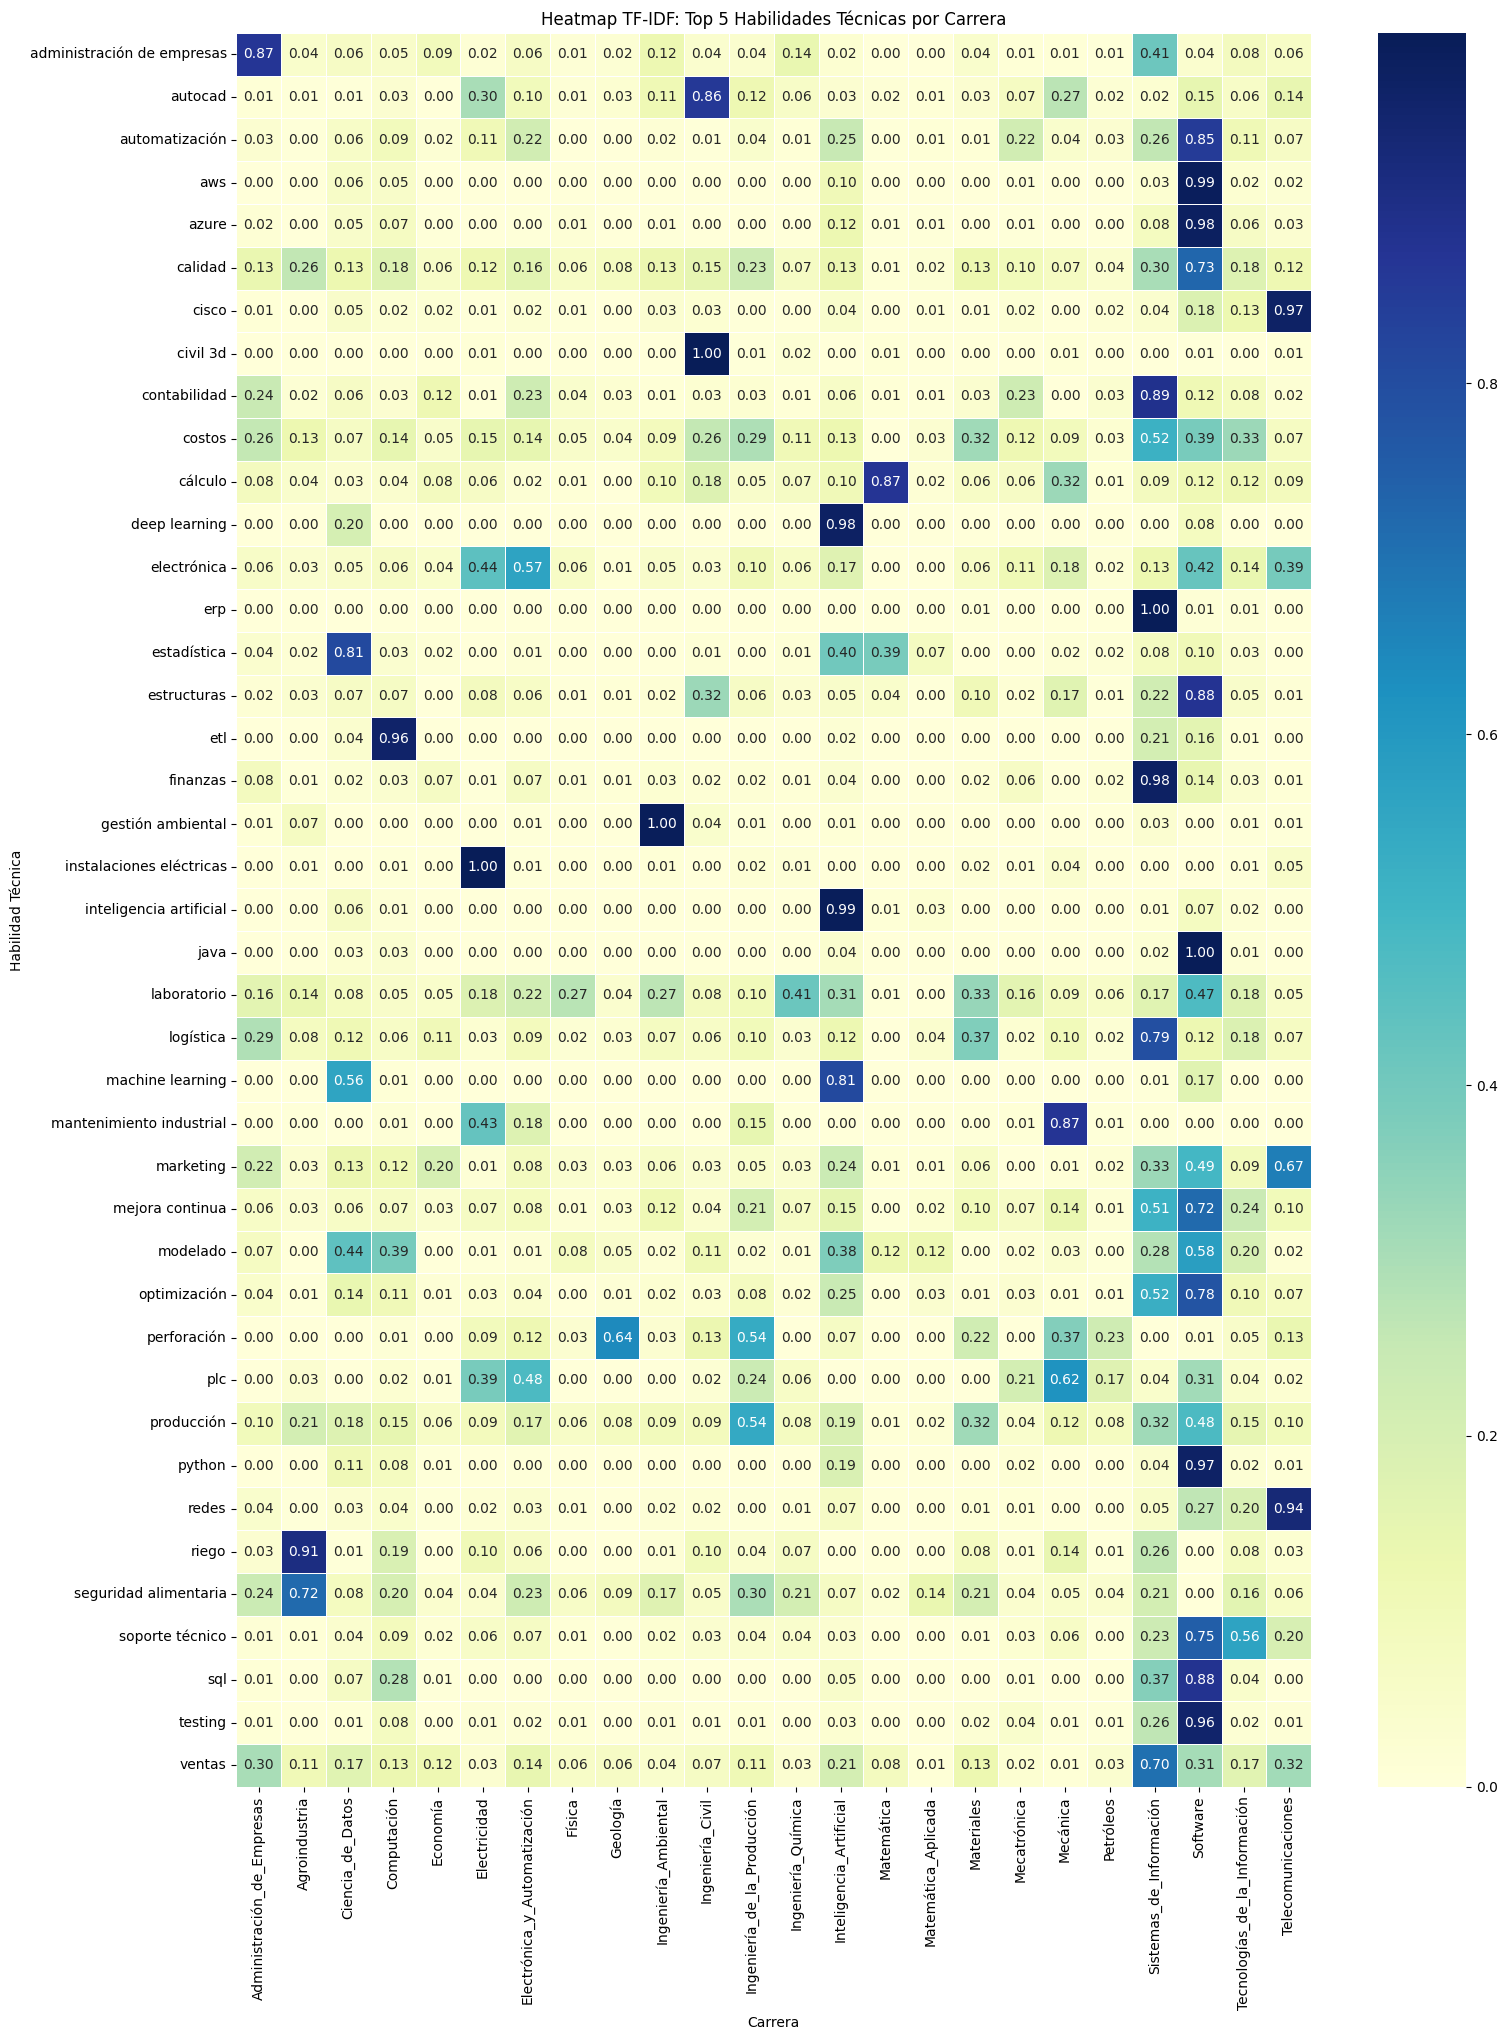

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Obtener el top 5 de cada carrera (sin duplicados globales)
top_habs = set()
for carrera in matriz_td.columns:
    top = matriz_td[carrera][matriz_td[carrera] > 0].sort_values(ascending=False).head(5).index.tolist()
    top_habs.update(top)
top_habs = sorted(top_habs)

# 2. Filtrar la matriz solo con esas habilidades
tfidf_base = matriz_td.loc[top_habs]

# 3. Calcular TF-IDF sobre la matriz filtrada
tfidf = TfidfTransformer(norm='l2').fit_transform(tfidf_base.values)
tfidf_df = pd.DataFrame(tfidf.toarray(), index=top_habs, columns=matriz_td.columns)

# 4. Visualizar heatmap
plt.figure(figsize=(16, max(6, len(top_habs)*0.5)))
sns.heatmap(tfidf_df, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap TF-IDF: Top 5 Habilidades Técnicas por Carrera')
plt.xlabel('Carrera')
plt.ylabel('Habilidad Técnica')
plt.tight_layout()
plt.show()

In [23]:
# Mostrar la matriz TF-IDF antes del heatmap
tfidf_df

,Administración_de_Empresas,Agroindustria,Ciencia_de_Datos,Computación,Economía,Electricidad,Electrónica_y_Automatización,Física,Geología,Ingeniería_Ambiental,Ingeniería_Civil,Ingeniería_de_la_Producción,Ingeniería_Química,Inteligencia_Artificial,Matemática,Matemática_Aplicada,Materiales,Mecatrónica,Mecánica,Petróleos,Sistemas_de_Información,Software,Tecnologías_de_la_Información,Telecomunicaciones
administración de empresas,0.870303,0.043204,0.062725,0.051078,0.093261,0.016458,0.063239,0.013387,0.021190,0.124555,0.036589,0.035624,0.137780,0.024911,0.000000,0.000000,0.040323,0.010206,0.010709,0.005486,0.411054,0.038272,0.082697,0.060807
autocad,0.009450,0.006943,0.006300,0.029315,0.000000,0.304143,0.096738,0.012907,0.025539,0.114089,0.859925,0.120219,0.055352,0.030023,0.015343,0.007870,0.031242,0.070728,0.271051,0.019835,0.023452,0.147606,0.055698,0.140710
automatización,0.031148,0.004735,0.056925,0.091961,0.022545,0.107089,0.215908,0.003851,0.001451,0.016892,0.007518,0.042945,0.011010,0.248771,0.003924,0.010734,0.010653,0.217053,0.040710,0.029872,0.260390,0.854582,0.110453,0.065472
aws,0.002743,0.000000,0.057771,0.053127,0.001439,0.000000,0.003510,0.000702,0.000000,0.002614,0.000343,0.002181,0.000669,0.103431,0.000000,0.000857,0.000756,0.005523,0.000000,0.000360,0.026484,0.990596,0.024090,0.022655
azure,0.015803,0.001201,0.047135,0.071758,0.004003,0.000000,0.004057,0.012560,0.000736,0.007012,0.001635,0.001486,0.001596,0.122056,0.005309,0.007488,0.000601,0.006118,0.001116,0.000572,0.081140,0.982567,0.064151,0.031188
calidad,0.134051,0.258467,0.126218,0.176613,0.056605,0.120490,0.160368,0.059606,0.081046,0.129691,0.150387,0.232645,0.067728,0.131824,0.008448,0.020129,0.126767,0.099407,0.072902,0.036171,0.303033,0.726439,0.179112,0.119755
cisco,0.010822,0.000000,0.048701,0.020144,0.022717,0.005679,0.020144,0.005543,0.000000,0.030947,0.027056,0.004917,0.000000,0.041262,0.000000,0.006760,0.005963,0.021131,0.000000,0.017038,0.037770,0.184897,0.128417,0.969423
civil 3d,0.000000,0.000000,0.000000,0.000000,0.000000,0.008359,0.000000,0.000000,0.000000,0.000000,0.999494,0.007237,0.023325,0.000000,0.009698,0.000000,0.000000,0.000000,0.008158,0.000000,0.000000,0.007775,0.000000,0.011118
contabilidad,0.243561,0.022062,0.064505,0.031051,0.119057,0.005836,0.228740,0.041015,0.025549,0.008480,0.025579,0.027287,0.010857,0.055123,0.008126,0.005557,0.033093,0.228007,0.000000,0.032682,0.887014,0.116175,0.080732,0.022770
costos,0.256487,0.125023,0.069054,0.144597,0.049179,0.147536,0.144597,0.053055,0.043324,0.089326,0.256487,0.293582,0.105938,0.126937,0.000000,0.030809,0.317995,0.117976,0.093477,0.025884,0.516416,0.390043,0.325916,0.073446


## 6. Ranking global de términos técnicos por número de apariciones
A continuación se muestra una tabla donde cada fila es un término técnico, la primera columna indica el número total de apariciones en todos los documentos (carreras), y las siguientes columnas muestran el conteo por carrera. La tabla está ordenada de mayor a menor según el total global.

In [25]:
# Crear ranking global de términos técnicos por número de apariciones (solo términos con al menos 1 aparición)
matriz_ranking = matriz_td.copy()
matriz_ranking['total'] = matriz_ranking.sum(axis=1)
matriz_ranking = matriz_ranking[matriz_ranking['total'] > 0]
matriz_ranking = matriz_ranking[['total'] + [col for col in matriz_td.columns]]
matriz_ranking = matriz_ranking.sort_values('total', ascending=False)
matriz_ranking

,total,Administración_de_Empresas,Agroindustria,Ciencia_de_Datos,Computación,Economía,Electricidad,Electrónica_y_Automatización,Física,Geología,Ingeniería_Ambiental,Ingeniería_Civil,Ingeniería_de_la_Producción,Ingeniería_Química,Inteligencia_Artificial,Matemática,Matemática_Aplicada,Materiales,Mecatrónica,Mecánica,Petróleos,Sistemas_de_Información,Software,Tecnologías_de_la_Información,Telecomunicaciones
habilidad,,,,,,,,,,,,,,,,,,,,,,,,,
erp,20364,36,14,6,31,56,5,33,9,0,10,2,20,6,16,0,2,102,19,4,8,19440,276,253,16
calidad,16222,599,1048,564,848,241,513,770,260,268,608,672,1144,310,618,31,72,514,455,318,154,1455,3325,860,575
producción,8124,209,420,385,337,122,184,387,118,125,205,188,1293,167,439,18,28,622,87,254,163,740,1058,353,222
sql,7987,36,0,304,1347,29,0,14,8,0,22,0,8,6,230,10,13,0,31,0,0,1730,3979,207,13
aws,7810,16,0,337,333,8,0,22,4,0,16,2,14,4,633,0,4,4,33,0,2,166,5919,151,142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
teoría cuántica,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
vision artificial,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
simulación de procesos,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
